In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import zipfile
import scipy.stats 
from scipy.stats import pearsonr, spearmanr 
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, explained_variance_score


### Connect to Kaggle account and get the dataset

In [4]:
kaggle datasets download -d brijlaldhankour/flood-prediction-factors


  0%|          | 0.00/680k [00:00<?, ?B/s]
100%|██████████| 680k/680k [00:01<00:00, 528kB/s]
100%|██████████| 680k/680k [00:01<00:00, 527kB/s]


In [3]:
with zipfile.ZipFile("flood-prediction-factors.zip", "r") as zip_ref:
    zip_ref.extractall("flood_prediction_factors")

In [5]:
# Adjust the file path to match the actual CSV file inside the extracted folder
data = pd.read_csv("flood_prediction_factors/flood.csv")

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


### EDA on our dataset

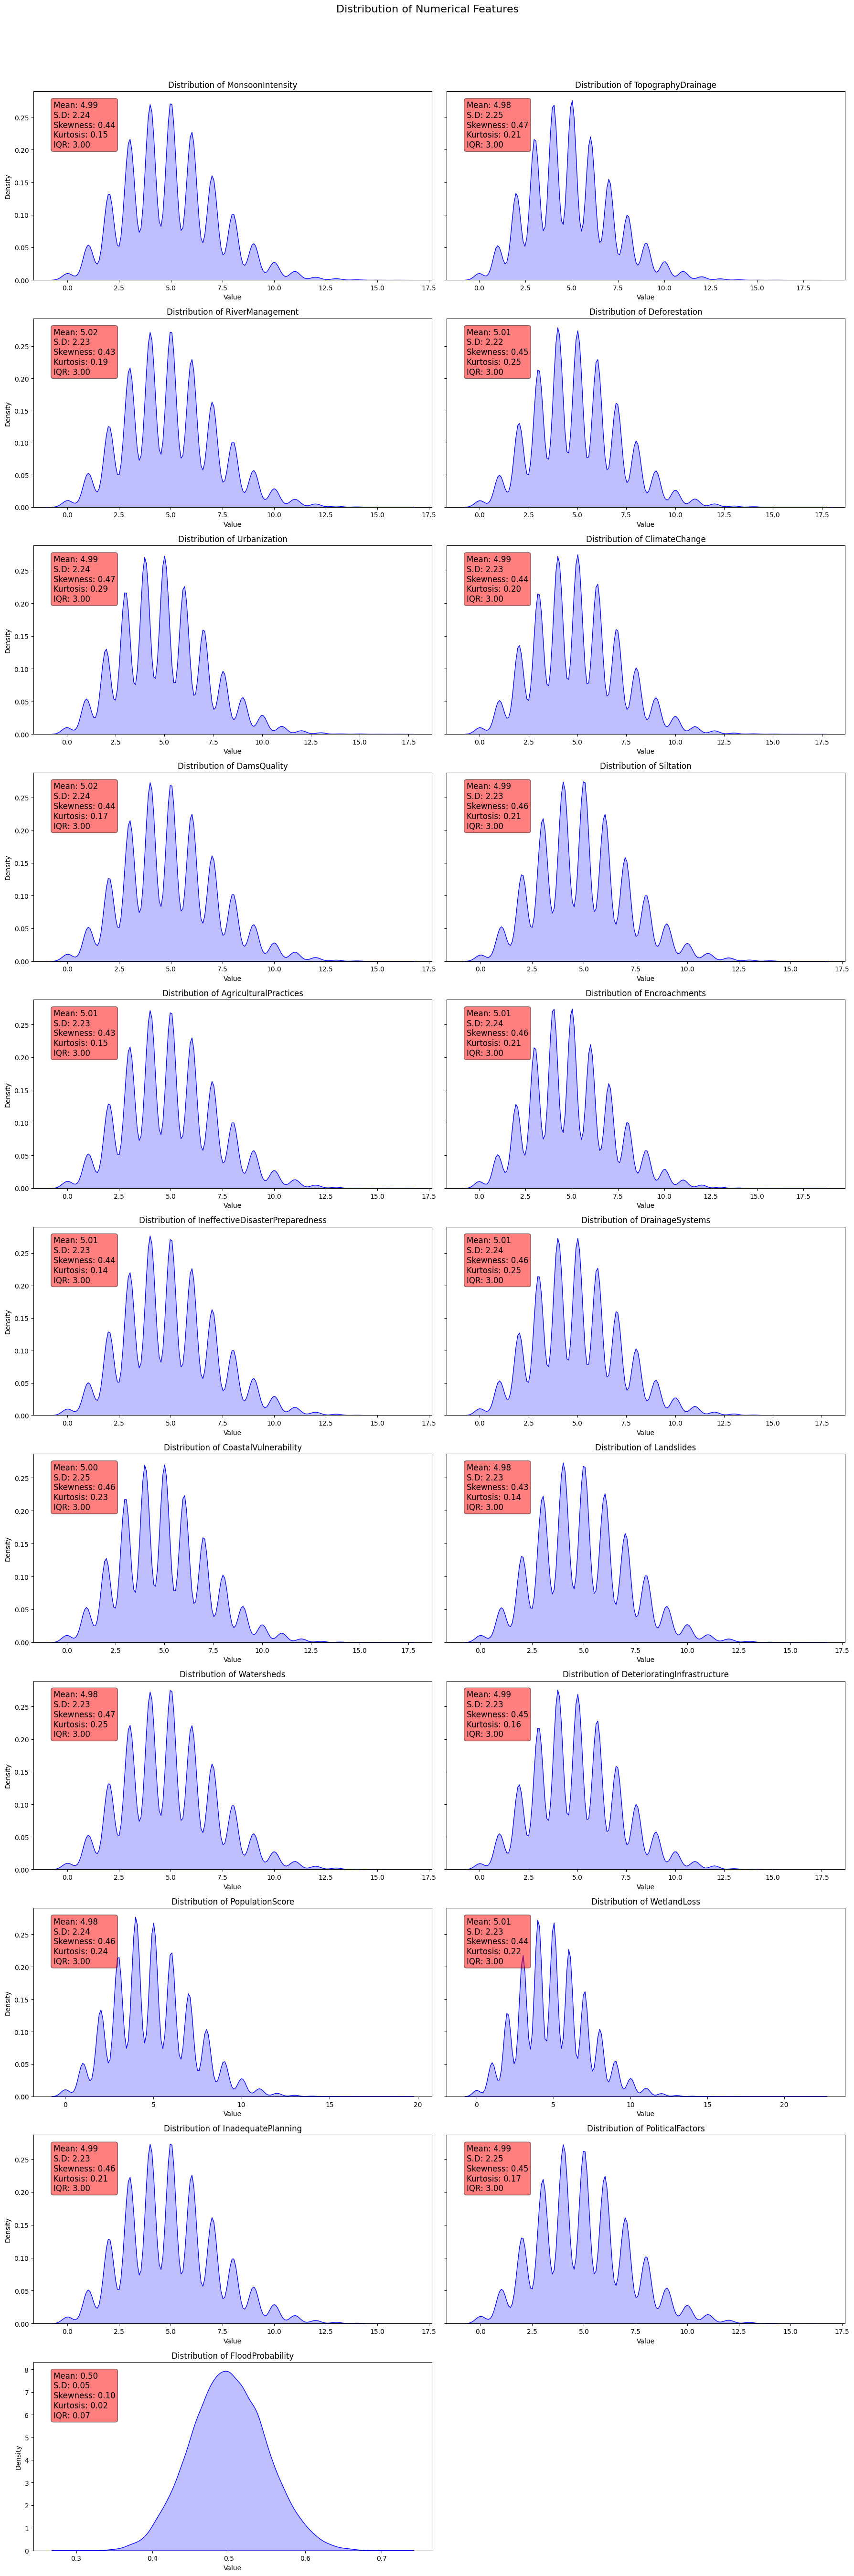

In [41]:
def plot_distributions(data: pd.DataFrame, target: str = None):
    """Plot the distributions of the data for EDA.
    
    Args:
        data (pd.DataFrame): The data to plot.
        target (str, optional): The target column. Defaults to None.
        
    Returns:
        None
    """
    
    num_columns = data.select_dtypes(include=[np.number]).columns
    n_cols = 2
    n_rows = int(np.ceil(len(num_columns) / n_cols))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 5), sharey='row')
    fig.suptitle('Distribution of Numerical Features', fontsize=16)
    
    axes = axes.flatten()
    
    for i, column in enumerate(num_columns):
        sns.kdeplot(data[column], color='blue', label='Original', fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')
        
        # Calculate central tendency and dispersion
        col_mean = data[column].mean()
        col_std = data[column].std()
        col_skew = data[column].skew()
        col_kurt = data[column].kurt()
        col_iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
        
        # Text box for original data statistics
        textstr_original = f'Mean: {col_mean:.2f}\nS.D: {col_std:.2f}\nSkewness: {col_skew:.2f}\nKurtosis: {col_kurt:.2f}\nIQR: {col_iqr:.2f}'
        props = dict(boxstyle='round', facecolor='red', alpha=0.5)
        axes[i].text(0.05, 0.95, textstr_original, transform=axes[i].transAxes, fontsize=12,
                     verticalalignment='top', bbox=props)      
        
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

        

# Plot distributions for a selected column
plot_distributions(df, "FloodProbability")

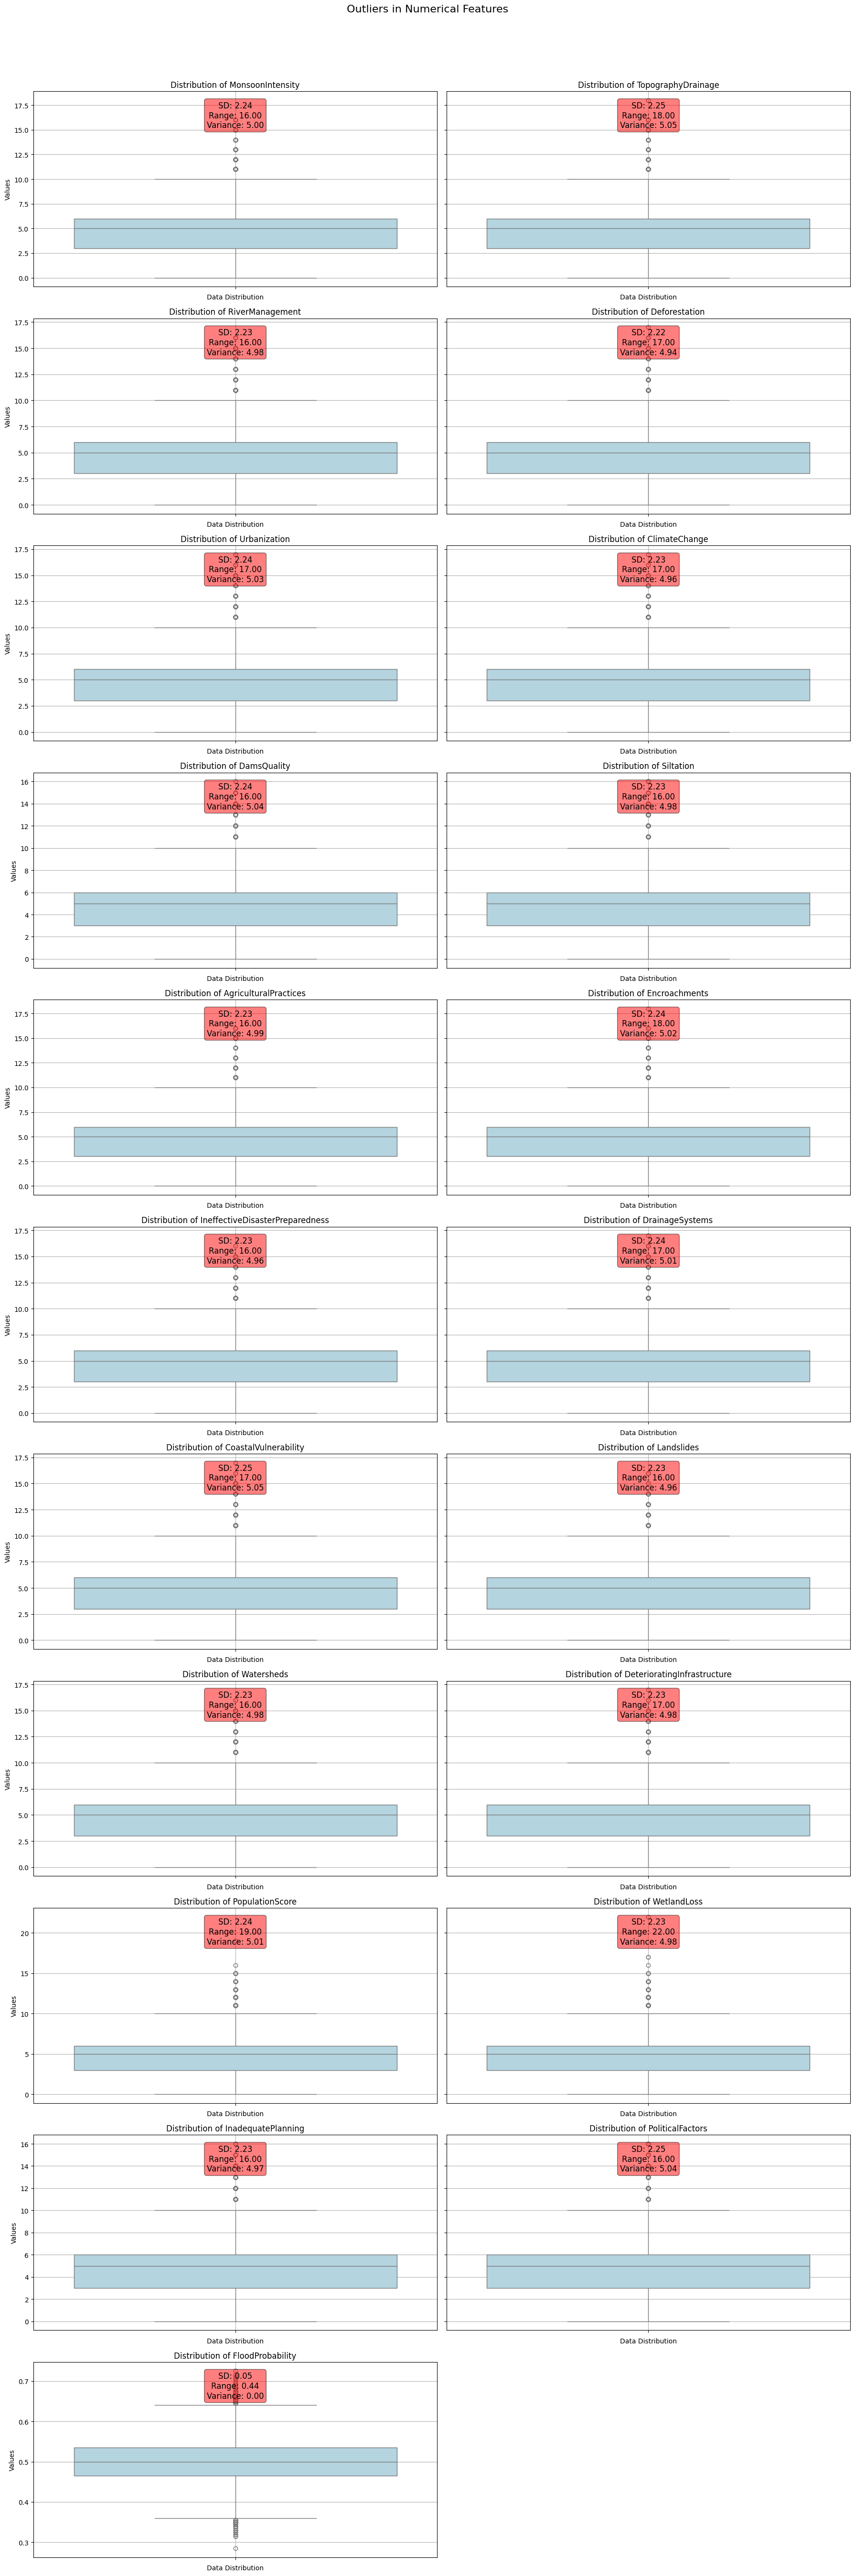

In [46]:
def plot_outliers(data: pd.DataFrame, target: str = None):
    """Plot the distributions of the data for EDA.
    
    Args:
        data (pd.DataFrame): The data to plot.
        target (str, optional): The target column. Defaults to None.
        
    Returns:
        None
    """
    
    num_columns = data.select_dtypes(include=[np.number]).columns
    n_cols = 2
    n_rows = int(np.ceil(len(num_columns) / n_cols))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 5), sharey='row')
    fig.suptitle('Outliers in Numerical Features', fontsize=16)
    
    axes = axes.flatten()
    
    for i, column in enumerate(num_columns):
        # Boxplot for the original data column
        sns.boxplot(ax=axes[i], y=data[column], color='lightblue')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel('Data Distribution')
        axes[i].set_ylabel('Values')
        axes[i].grid(True)
        
        # Annotate boxplot with standard deviation and range
        std = data[column].std()
        data_min = data[column].min()
        data_max = data[column].max()
        range_data = data_max - data_min
        variance = data[column].var()
        textstr = f'SD: {std:.2f}\nRange: {range_data:.2f}\nVariance: {variance:.2f}'
        
        props = dict(boxstyle='round', facecolor='red', alpha=0.5)
        axes[i].text(0.5, 0.95, textstr, transform=axes[i].transAxes, fontsize=12,
                     verticalalignment='top', bbox=props, ha='center')
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_outliers(df)

### MLR Analysis

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.498e+31
Date:                Sun, 02 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:22:55   Log-Likelihood:             1.7053e+06
No. Observations:               50000   AIC:                        -3.411e+06
Df Residuals:                   49979   BIC:                        -3.410e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

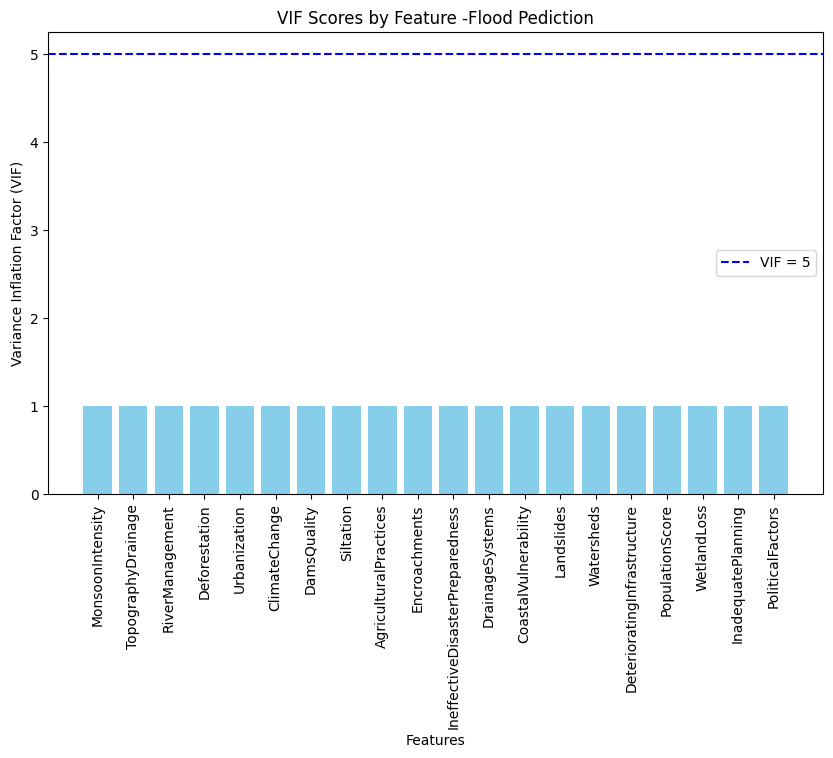

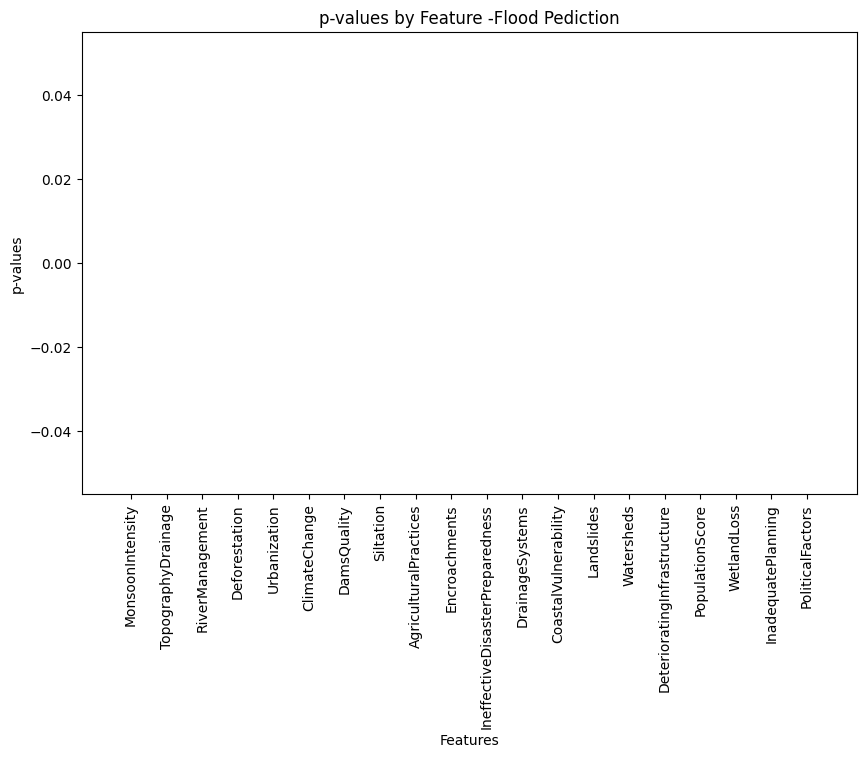

C:\Users\Ranojoy Deb\AppData\Local\Temp\ipykernel_12440\3051098445.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_features, y=sorted_eigenvalues, palette="coolwarm")


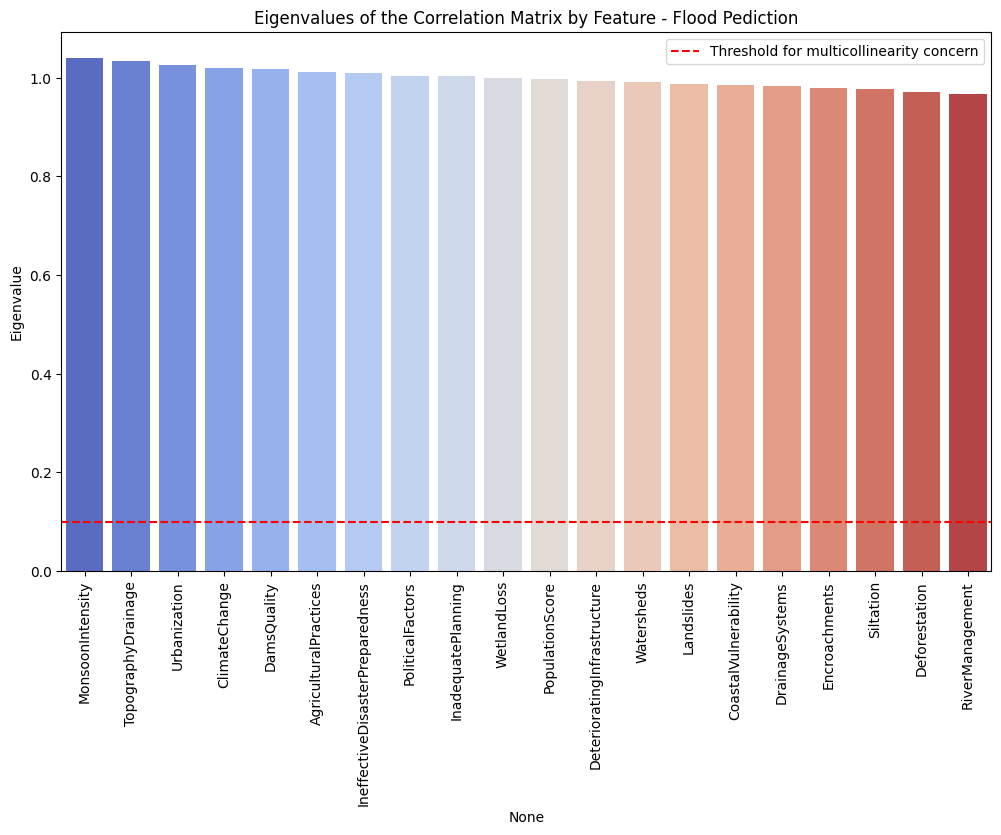

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


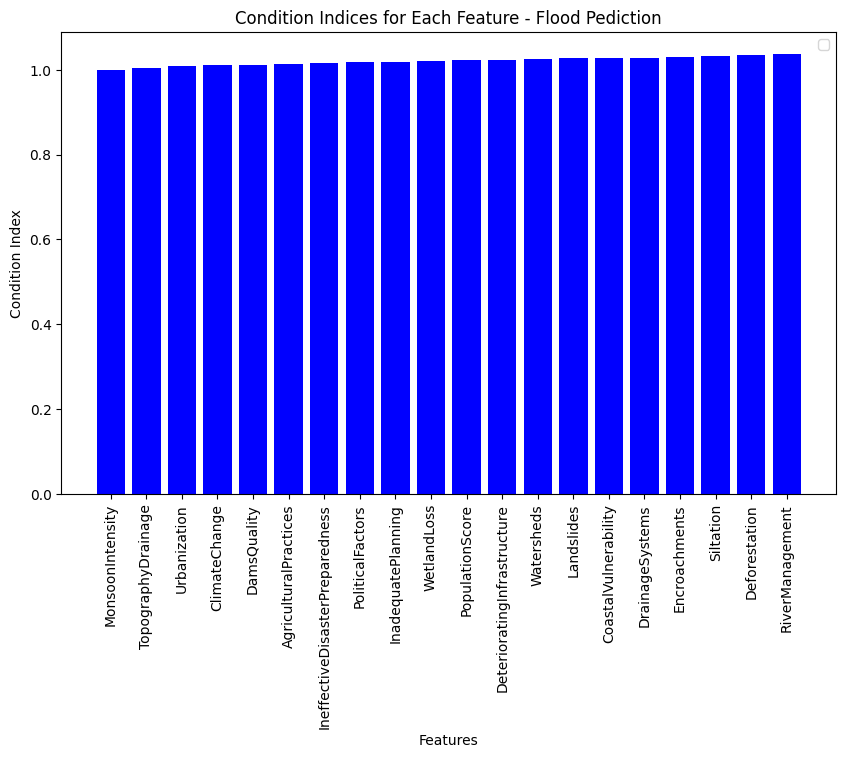

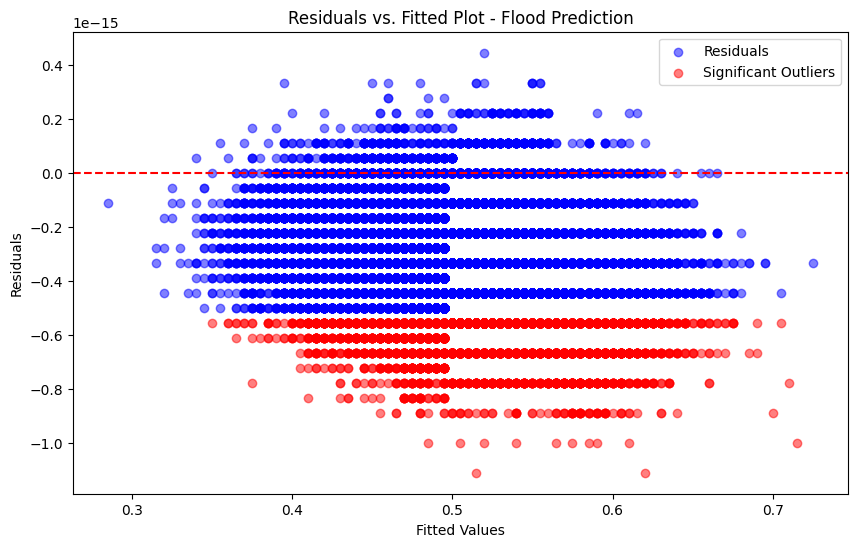

In [57]:
# Prepare the data for MLR
X = sm.add_constant(df.drop(["FloodProbability"], axis=1))
Y = df["FloodProbability"]

# Perform Multiple Linear Regression
model = OLS(Y, X).fit()

# Calculate VIF scores
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Correlation matrices and eigenvalues
pearson_corr = df.drop(["FloodProbability"], axis=1).corr(method='pearson')
spearman_corr = df.drop(["FloodProbability"], axis=1).corr(method='spearman')

# Get summary of the model:
print(model.summary())

# Eigenvalues and condition indices calculation
eigenvalues, _ = np.linalg.eig(pearson_corr)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_features = X.columns.drop('const')[sorted_indices]

# Condition Indices
condition_indices = np.sqrt(eigenvalues.max() / eigenvalues)

# Summarize eigenvalues with feature names
eigen_summary = pd.DataFrame({"Eigenvalue": sorted_eigenvalues}, index=sorted_features)
eigen_summary["Multicollinearity Indicator"] = eigen_summary["Eigenvalue"].apply(lambda x: "Potential Issue" if x < 0.1 else "Okay")

# Plot the VIF scores for the features
plt.figure(figsize=(10, 6))
plt.bar(vif_data.drop(index=[0])['Feature'], vif_data.drop(index=[0])['VIF'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.axhline(y=5, color='blue', linestyle='--', label='VIF = 5')
plt.title('VIF Scores by Feature -Flood Pediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Plot the p-values from the MLR analysis, excluding the constant
p_values = model.pvalues.drop('const')  # Drop the constant term if present
plt.figure(figsize=(10, 6))
plt.bar(p_values.index, p_values, color='salmon')
plt.xlabel('Features')
plt.ylabel('p-values')
plt.title('p-values by Feature -Flood Pediction')
plt.xticks(rotation=90)
plt.show()

# Plotting the eigenvalues to identify potential multicollinearity
plt.figure(figsize=(12, 7))
sns.barplot(x=sorted_features, y=sorted_eigenvalues, palette="coolwarm")
plt.title('Eigenvalues of the Correlation Matrix by Feature - Flood Pediction')
plt.ylabel('Eigenvalue')
plt.axhline(y=0.1, color='red', linestyle='--', label='Threshold for multicollinearity concern')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Plotting Condition Indices
condition_indices = np.sqrt(eigenvalues.max() / eigenvalues)
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, condition_indices[sorted_indices], color='b')
plt.title('Condition Indices for Each Feature - Flood Pediction')
plt.xlabel('Features')
plt.ylabel('Condition Index')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Extract residuals and fitted values
residuals = model.resid
fitted = model.fittedvalues
r_squared = model.rsquared  # R-squared value

# Prepare the regression equation using actual variable names
coef = model.params
variables = X.columns  # Adjust this if your model's input X doesn't directly use DataFrame columns
equation = f"y = {coef.iloc[0]:.2f} + " + " + ".join([f"{coef.iloc[i]:.2f}*{variables[i-1]}" for i in range(1, len(coef))])


# Identify significant outliers
threshold = 3 * residuals.std()
outliers = abs(residuals) > threshold

# Plot regular residuals
plt.figure(figsize=(10, 6))
plt.scatter(fitted[~outliers], residuals[~outliers], alpha=0.5, label='Residuals', color='blue')

# Plot significant outliers
plt.scatter(fitted[outliers], residuals[outliers], alpha=0.5, label='Significant Outliers', color='red')

# Add a horizontal line at 0 to help identify deviations
plt.axhline(y=0, color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Plot - Flood Prediction')

# Adding legend
plt.legend()

# Display plot
plt.show()

 

In [69]:
# Dropping non-numeric columns for simplicity, replace with actual feature selection as needed
features = df.select_dtypes(include=[np.number]).drop(['FloodProbability'], axis=1)
target = df['FloodProbability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scaling the input datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=42),
    'PLS Regression': PLSRegression()
    # 'Random Forrest': RandomForrestRegressor(random_state=42),
    # 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    # 'Support Vector Machine': SVR(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),
    # 'XGBoost Regressor': XGBRegressor(random_state=42),
    # 'LightGBM Regressor': LGBMRegressor(random_state=42),
    # 'KNN Regressor': KNeighborsRegressor(),
    
}

def train_and_predict(models, X_train_scaled, y_train, X_test_scaled):
    predictions = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)  # Train model
        predictions[name] = model.predict(X_test_scaled)  # Predict scores
    return predictions

def evaluate_predictions(predictions, y_test):
    evaluation_results = {}
    for name, pred in predictions.items():
        mse = mean_squared_error(y_test, pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        mape = mean_absolute_percentage_error(y_test, pred)
        evaluation_results[name] = {'RMSE': rmse, 'MAPE': mape, 'MAE': mae, 'R-Squared': r2}
    return pd.DataFrame(evaluation_results).T

predictions = train_and_predict(models, X_train_scaled, y_train, X_test_scaled)
evaluation_df = evaluate_predictions(predictions, y_test)
print(evaluation_df)

                           RMSE          MAPE           MAE  R-Squared
Linear Regression  3.958276e-16  6.274054e-16  3.126943e-16   1.000000
ElasticNet         4.991080e-02  8.095339e-02  3.982173e-02  -0.000202
PLS Regression     2.657677e-05  4.244661e-05  2.112249e-05   1.000000
